In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch

from utils.consts import *
from utils.dataset_utils import create_hbw_csv, HBWDataset, get_datasets, get_dataloader

from tqdm.notebook import tqdm
import cv2
import os

Seed set to 42


Device: cpu


In [16]:
DATA_DIR = "..\\data\\HBW\\images\\val\\"

subj_samples = os.listdir(DATA_DIR)
subj_ids = []
photos_lab = []
pics_in_the_wild = []

for subject in subj_samples:
    subj_id, lab, wild = subject.split("_")
    subj_ids.append(subj_id)
    photos_lab.append(int(lab))
    pics_in_the_wild.append(int(wild))
    print(f"Subject ID: {subj_id}, Photos in lab: {lab}, Pictures in the wild: {wild}")

print("Total number of subjects:", len(subj_ids))
print("Total subject photos in lab:", sum(photos_lab))
print("Total subject pictures in the wild:", sum(pics_in_the_wild))

Subject ID: 012, Photos in lab: 13, Pictures in the wild: 20
Subject ID: 017, Photos in lab: 111, Pictures in the wild: 48
Subject ID: 018, Photos in lab: 10, Pictures in the wild: 20
Subject ID: 020, Photos in lab: 12, Pictures in the wild: 25
Subject ID: 022, Photos in lab: 12, Pictures in the wild: 34
Subject ID: 023, Photos in lab: 15, Pictures in the wild: 33
Subject ID: 026, Photos in lab: 71, Pictures in the wild: 51
Subject ID: 027, Photos in lab: 73, Pictures in the wild: 23
Subject ID: 029, Photos in lab: 66, Pictures in the wild: 21
Subject ID: 033, Photos in lab: 85, Pictures in the wild: 38
Total number of subjects: 10
Total subject photos in lab: 468
Total subject pictures in the wild: 313


In [10]:
468+313

781

In [3]:
subj_samples

['012_13_20',
 '017_111_48',
 '018_10_20',
 '020_12_25',
 '022_12_34',
 '023_15_33',
 '026_71_51',
 '027_73_23',
 '029_66_21',
 '033_85_38']

**Observations**
- Really small data
- Might have to rely on pretrained models
- Be really careful of overfitting 

In [17]:
img_sizes = {}
img_paths = []
count = 0
for root, dirs, imgs in os.walk(DATA_DIR):
    if len(imgs) == 0:
        continue
    for img in imgs:
        count +=1
        img_path = os.path.join(root, img)
        root.split("\\")[-2:]
        
        key = "|".join(root.split("\\")[-2:])
        
        img = cv2.imread(img_path)
        
        if key not in img_sizes:
            img_sizes[key] = set()
        
        img_sizes[key].add(img.shape)

print(img_sizes)

{'012_13_20|Photos_Lab': {(5760, 3840, 3)}, '012_13_20|Pictures_in_the_Wild': {(2969, 2197, 3), (2792, 2712, 3), (1280, 720, 3), (3027, 2681, 3), (4032, 3024, 3), (2753, 2129, 3), (2310, 1898, 3), (2721, 2045, 3), (2048, 1536, 3)}, '017_111_48|Photos_Lab': {(5760, 3840, 3), (5120, 3840, 3)}, '017_111_48|Pictures_in_the_Wild': {(1200, 1600, 3), (4000, 6000, 3), (3024, 4032, 3), (1024, 768, 3), (1600, 1200, 3), (1280, 720, 3), (3120, 4160, 3), (4608, 3456, 3), (4160, 3120, 3)}, '018_10_20|Photos_Lab': {(5120, 3840, 3)}, '018_10_20|Pictures_in_the_Wild': {(828, 641, 3), (365, 535, 3), (598, 601, 3), (1600, 1200, 3), (985, 643, 3), (731, 686, 3), (677, 529, 3), (696, 461, 3), (633, 620, 3), (948, 750, 3), (701, 483, 3)}, '020_12_25|Photos_Lab': {(5120, 3840, 3)}, '020_12_25|Pictures_in_the_Wild': {(1200, 1600, 3), (1920, 1440, 3), (4032, 3024, 3), (3264, 2448, 3)}, '022_12_34|Photos_Lab': {(5120, 3840, 3)}, '022_12_34|Pictures_in_the_Wild': {(2976, 3968, 3), (2947, 3773, 3), (3000, 2930, 3

In [13]:
import yaml

with open(YAML_PATH, "r") as stream:
    try:
        genders_dict = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
        
hbw_dict = {"ImagePaths": [],
            "Genders": [],
            "SMPLxVertPaths": []}
        
for root, dirs, imgs in os.walk(IMAGES_DIR):
    if len(imgs) == 0:
        continue
    for img in imgs:
        img_path = os.path.join(root, img)
        subj_id = root.split("\\")[-2].split("_")[0]
        gender = genders_dict[subj_id]
        smplx_vert_path = os.path.join(SMPLX_VERTICES_PATH, f'{subj_id}.npy')
        
        hbw_dict["ImagePaths"].append(img_path)
        hbw_dict["Genders"].append(gender)
        hbw_dict["SMPLxVertPaths"].append(smplx_vert_path)
        
        
        
        


In [20]:
hbw_df = pd.DataFrame(hbw_dict)
hbw_df

,ImagePaths,Genders,SMPLxVertPaths
0,..\data\HBW\images\val\012_13_20\Photos_Lab\00...,female,..\data\HBW\smplx\val\012.npy
1,..\data\HBW\images\val\012_13_20\Photos_Lab\00...,female,..\data\HBW\smplx\val\012.npy
2,..\data\HBW\images\val\012_13_20\Photos_Lab\00...,female,..\data\HBW\smplx\val\012.npy
3,..\data\HBW\images\val\012_13_20\Photos_Lab\00...,female,..\data\HBW\smplx\val\012.npy
4,..\data\HBW\images\val\012_13_20\Photos_Lab\00...,female,..\data\HBW\smplx\val\012.npy
...,...,...,...
700,..\data\HBW\images\val\033_85_38\Pictures_in_t...,male,..\data\HBW\smplx\val\033.npy
701,..\data\HBW\images\val\033_85_38\Pictures_in_t...,male,..\data\HBW\smplx\val\033.npy
702,..\data\HBW\images\val\033_85_38\Pictures_in_t...,male,..\data\HBW\smplx\val\033.npy
703,..\data\HBW\images\val\033_85_38\Pictures_in_t...,male,..\data\HBW\smplx\val\033.npy


In [2]:
print(create_hbw_csv(YAML_PATH, IMAGES_DIR, SMPLX_VERTICES_PATH, CSV_PATH))
transform = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                transforms.ToTensor()])
dataset = HBWDataset(CSV_PATH, transform)

705


In [4]:
# dataset[1]['X'][0].transpose(2,0,1).shape
dataset[1]['X'][0].shape

torch.Size([3, 768, 768])

In [4]:
transform = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                transforms.ToTensor()])
trainset, testset = get_datasets(CSV_PATH, transform)

In [7]:
tr, val = get_dataloader(trainset, type='train')

for batch in val:
    (imgs, genders), y = batch['X'], batch['y']
    print(imgs.shape)
    print(genders)
    print(y.shape)
    break

torch.Size([4, 3, 768, 768])
('male', 'male', 'male', 'male')
torch.Size([4, 10475, 3])


In [32]:
len(trainset), len(testset)

(635, 70)

In [9]:
batch = next(iter(torch.utils.data.DataLoader(dataset, batch_size=4)))
print(batch['X'])

[tensor([[[[0.7294, 0.7294, 0.7333,  ..., 0.8078, 0.8078, 0.8118],
          [0.7412, 0.7412, 0.7412,  ..., 0.8118, 0.8118, 0.8118],
          [0.7490, 0.7490, 0.7490,  ..., 0.8196, 0.8196, 0.8196],
          ...,
          [0.9765, 0.9765, 0.9765,  ..., 0.9922, 0.9922, 0.9922],
          [0.9765, 0.9765, 0.9765,  ..., 0.9922, 0.9922, 0.9922],
          [0.9765, 0.9765, 0.9765,  ..., 0.9922, 0.9922, 0.9922]],

         [[0.8039, 0.8039, 0.8078,  ..., 0.8706, 0.8706, 0.8706],
          [0.8118, 0.8118, 0.8118,  ..., 0.8784, 0.8745, 0.8745],
          [0.8157, 0.8157, 0.8196,  ..., 0.8784, 0.8784, 0.8784],
          ...,
          [0.9922, 0.9922, 0.9922,  ..., 0.9961, 0.9961, 0.9961],
          [0.9922, 0.9922, 0.9922,  ..., 0.9961, 0.9961, 0.9961],
          [0.9882, 0.9922, 0.9922,  ..., 0.9961, 0.9961, 0.9961]],

         [[0.8314, 0.8314, 0.8353,  ..., 0.9020, 0.9020, 0.9059],
          [0.8392, 0.8392, 0.8431,  ..., 0.9098, 0.9098, 0.9059],
          [0.8471, 0.8471, 0.8471,  ..., 

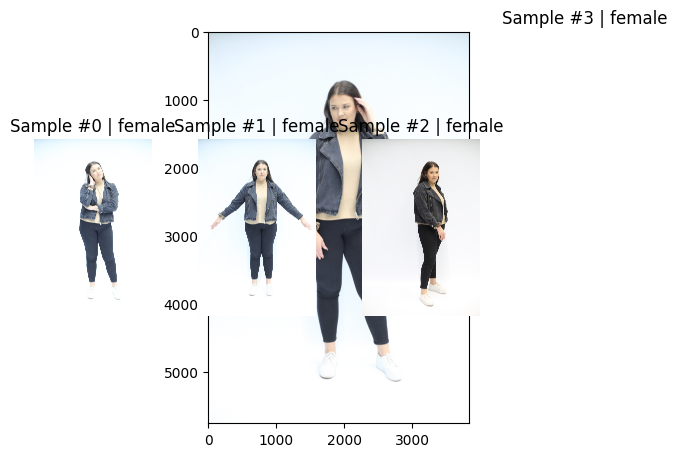

In [6]:
fig = plt.figure()

for i,sample in enumerate(dataset):
    plt.imshow(sample["X"][0])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{} | {}'.format(i, sample["X"][1]))
    # ax.set_xlabel(f"SMPLX_VERT_DIM {sample["y"].shape}")
    ax.axis('off')
    if i==3:
        plt.show()
        break

In [27]:
count_dict = {}

for i in range(len(hbw_df)):
    subj = hbw_df.iloc[i,2]
    if subj not in count_dict:
        count_dict[subj] = [0,0]
    img_path = hbw_df.iloc[i,0]
    if 'Photos_Lab' in img_path:
        count_dict[subj][0] += 1
    elif 'Pictures_in_the_Wild' in img_path:
        count_dict[subj][1] += 1
    else:
        print("ERROR!!", img_path, subj)        


In [28]:
count_dict

{'..\\data\\HBW\\smplx\\val\\012.npy': [13, 18],
 '..\\data\\HBW\\smplx\\val\\017.npy': [111, 37],
 '..\\data\\HBW\\smplx\\val\\018.npy': [10, 16],
 '..\\data\\HBW\\smplx\\val\\020.npy': [12, 22],
 '..\\data\\HBW\\smplx\\val\\022.npy': [12, 33],
 '..\\data\\HBW\\smplx\\val\\023.npy': [15, 27],
 '..\\data\\HBW\\smplx\\val\\026.npy': [71, 8],
 '..\\data\\HBW\\smplx\\val\\027.npy': [73, 23],
 '..\\data\\HBW\\smplx\\val\\029.npy': [66, 16],
 '..\\data\\HBW\\smplx\\val\\033.npy': [85, 37]}

In [26]:
for root, dirs, imgs in os.walk('../data/HBW/images/val/'):
    print(root)

../data/HBW/images/val/
../data/HBW/images/val/012_13_20
../data/HBW/images/val/012_13_20\Photos_Lab
../data/HBW/images/val/012_13_20\Pictures_in_the_Wild
../data/HBW/images/val/017_111_48
../data/HBW/images/val/017_111_48\Photos_Lab
../data/HBW/images/val/017_111_48\Pictures_in_the_Wild
../data/HBW/images/val/018_10_20
../data/HBW/images/val/018_10_20\Photos_Lab
../data/HBW/images/val/018_10_20\Pictures_in_the_Wild
../data/HBW/images/val/020_12_25
../data/HBW/images/val/020_12_25\Photos_Lab
../data/HBW/images/val/020_12_25\Pictures_in_the_Wild
../data/HBW/images/val/022_12_34
../data/HBW/images/val/022_12_34\Photos_Lab
../data/HBW/images/val/022_12_34\Pictures_in_the_Wild
../data/HBW/images/val/023_15_33
../data/HBW/images/val/023_15_33\Photos_Lab
../data/HBW/images/val/023_15_33\Pictures_in_the_Wild
../data/HBW/images/val/026_71_51
../data/HBW/images/val/026_71_51\Photos_Lab
../data/HBW/images/val/026_71_51\Pictures_in_the_Wild
../data/HBW/images/val/027_73_23
../data/HBW/images/val/

In [4]:
H, W = 3760, 3760


img_np = cv2.imread(img_path)
img = torch.from_numpy(img_np.transpose((2,0,1)))
print(img.shape)

NameError: name 'img_path' is not defined

In [86]:
transform = transforms.Resize(size=(H,W))
img_trans = transform(img).numpy().transpose((1,2,0))

c:\Users\nikhi\OneDrive\Documents\Projects\Human_Body_Shape_Estimation\.venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


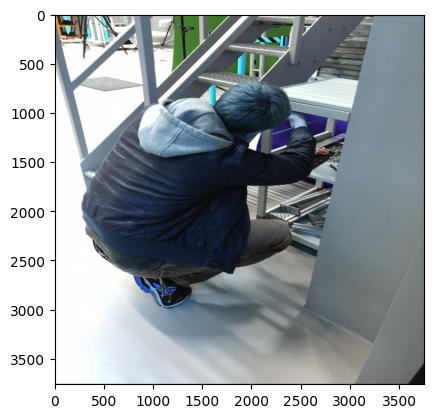

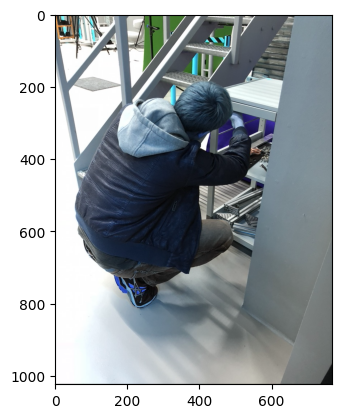

In [87]:
plt.imshow(img_trans)
plt.show()
plt.imshow(img_np)
plt.show()

In [200]:
from utils import img_to_strips

s = 235
test_img = transform(img).unsqueeze(0)

res_flat = img_to_strips(test_img, s, True, True)
res_unflat = img_to_strips(test_img, s, False, True)

c:\Users\nikhi\OneDrive\Documents\Projects\Human_Body_Shape_Estimation\.venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [202]:
res_flat.shape, res_unflat.shape

(torch.Size([1, 32, 2650800]), torch.Size([1, 32, 3, 235, 3760]))

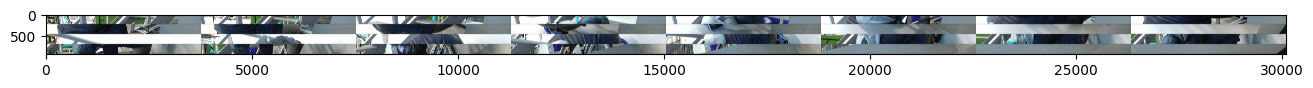

In [135]:
strips = torchvision.utils.make_grid(res_unflat.squeeze()).permute(1,2,0).numpy()

fig = plt.figure(figsize=(16,8))
plt.imshow(strips)
plt.show()

In [6]:
T, B, embed_size = 16, 64, 1024

embeds = torch.randn((T, B, embed_size))
gender_tokens = torch.randn((B, 2)).T.unsqueeze(2)

gender_tokens = gender_tokens.repeat((1,1,embed_size))
torch.cat((gender_tokens, embeds), dim=0).shape

torch.Size([18, 64, 1024])

In [8]:
pos_enc = torch.randn(2 + T, 1, embed_size)[:T+2,:,:]
x = (torch.cat((gender_tokens, embeds), dim=0) + pos_enc)

In [10]:
x.shape # [T+2, B, E]

torch.Size([18, 64, 1024])

In [11]:
x.transpose(0,1).flatten(1,2).shape

torch.Size([64, 18432])

In [52]:
import smplx

smpl= smplx.create(
        model_path='../data/models/',
        # gender='neutral',
        # create_betas=True,
        return_verts=True,
        batch_size=4,
        num_betas=10,
        model_type='smplx'
    )


In [63]:
out = torch.stack([smpl(betas = torch.randn([4,10])).vertices,
                    smpl(betas = torch.randn([4,10])).vertices,
                    smpl(betas = torch.randn([4,10])).vertices]).transpose(0,1)
out.shape

torch.Size([4, 3, 10475, 3])

In [66]:
ones = torch.ones(size=(10475, 3))
zeros = torch.zeros(size=(10475, 3))
encoding = {
    "male": torch.stack([zeros, zeros, ones]),
    "female": torch.stack([zeros, ones, zeros]),
    "neutral": torch.stack([ones, zeros, zeros]),
}
genders = ['male', 'female', 'neutral', 'male']

gender_tokens = torch.stack([encoding[gender] for gender in genders])

In [72]:
(gender_tokens * out).sum(axis=1).shape

torch.Size([4, 10475, 3])

In [45]:
for k in out.__dict__.keys():
    print(k)

vertices
joints
full_pose
global_orient
transl
v_shaped
betas
body_pose
left_hand_pose
right_hand_pose
expression
jaw_pose


In [46]:
out.betas

tensor([[-1.3678,  0.1606, -0.6877, -0.5058,  2.0048, -0.2737,  1.9907, -0.3327,
         -1.0013,  0.7415]])

In [26]:
np.load('..\\data\\HBW\\HBW\\smplx\\val\\012.npy').shape

(10475, 3)

In [203]:
from models import VisionTransformer

strip_thickness = 235
num_strips = 32
num_layers = 4
embed_size = 512
hidden_size = 2048
num_heads = 8
img_size = H
num_channels = 3
output_size = 10
genders = ['male']

In [204]:
vit = VisionTransformer(strip_thickness = 235,
num_strips = 32,
num_layers = 4,
embed_size = 512,
hidden_size = 2048,
num_heads = 8,
img_size = H,
num_channels = 3,
output_size = 10,
genders = ['male'],)

In [208]:
input_img.shape

torch.Size([1, 3, 3760, 3760])

In [1]:
768//32

24

In [206]:
input_img = transform(img).unsqueeze(0).type(torch.float)
vit(input_img)

torch.Size([16, 2, 2650800])
torch.Size([16, 2, 512])


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 1 but got size 2 for tensor number 1 in the list.